# Pipeline

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
print(X.shape)
print(y.shape)

(569, 30)
(569,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

Chaining:

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test Accuracy: 0.956


# K-fold cross validation

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    
    print(f'Fold: {k+1}, Class dist.: {np.bincount(y_train[train])}, Test accuracy: {score:.3f}')

Fold: 1, Class dist.: [256 153], Test accuracy: 0.935
Fold: 2, Class dist.: [256 153], Test accuracy: 0.935
Fold: 3, Class dist.: [256 153], Test accuracy: 0.957
Fold: 4, Class dist.: [256 153], Test accuracy: 0.957
Fold: 5, Class dist.: [256 153], Test accuracy: 0.935
Fold: 6, Class dist.: [257 153], Test accuracy: 0.956
Fold: 7, Class dist.: [257 153], Test accuracy: 0.978
Fold: 8, Class dist.: [257 153], Test accuracy: 0.933
Fold: 9, Class dist.: [257 153], Test accuracy: 0.956
Fold: 10, Class dist.: [257 153], Test accuracy: 0.956


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_lr, X_train, y_train, cv=10)
print(f'Cross-validation scores: {scores}')
print(f'Average CV score: {scores.mean():.3f} +/- {scores.std():.3f}')

Cross-validation scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Average CV score: 0.950 +/- 0.014


# Debugging

In [11]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

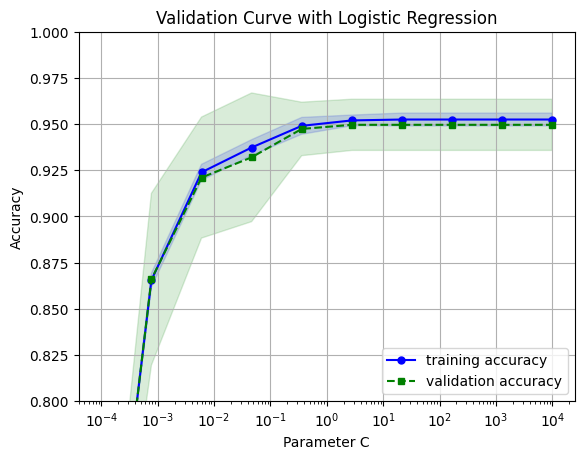

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are already defined
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())

param_range = np.logspace(-4, 4, 10)
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10,
    scoring='accuracy',
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.title('Validation Curve with Logistic Regression')
plt.show()

# Grid search fine-tuning

In [13]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

# Define the pipeline
pipe_svc = make_pipeline(StandardScaler(), SVC())

# Define the parameter grid
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

# Set up the GridSearchCV
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

# Fit the GridSearchCV
gs = gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {gs.best_params_}')
print(f'Best cross-validation accuracy: {gs.best_score_:.3f}')

# Evaluate the best model on the test set
best_model = gs.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.3f}')

Best parameters: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.985
Test accuracy: 0.974


## Randomized search

In [14]:
import scipy
param_range = scipy.stats.loguniform(0.001, 1000)
param_range.rvs(10)

array([1.86893013e+00, 5.97636497e+01, 5.63308181e+00, 1.59439486e-01,
       9.65200026e+00, 6.50236723e-02, 6.11038314e+00, 2.42852618e+00,
       6.20724310e+02, 2.97900127e+01])

In [15]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import scipy

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

# Define the pipeline
pipe_svc = make_pipeline(StandardScaler(), SVC())

# Define the parameter distributions
param_range = scipy.stats.loguniform(0.001, 1000) # create a log-uniform distribution

param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# Set up the RandomizedSearchCV
rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid, 
                        n_iter=50, scoring='accuracy', cv=10, random_state=1, n_jobs=-1)

# Fit the RandomizedSearchCV
rs = rs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {rs.best_params_}')
print(f'Best cross-validation accuracy: {rs.best_score_:.3f}')

# Evaluate the best model on the test set
best_model = rs.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.3f}')

Best parameters: {'svc__C': 0.23959864837279687, 'svc__kernel': 'linear'}
Best cross-validation accuracy: 0.982
Test accuracy: 0.974


In [16]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split

# Set up the HalvingRandomSearchCV
hs = HalvingRandomSearchCV(estimator=pipe_svc, param_distributions=param_grid, resource='n_samples', factor=1.5,
                           n_candidates='exhaust', scoring='accuracy', cv=10, random_state=1, n_jobs=-1)

# Fit the HalvingRandomSearchCV
hs = hs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {hs.best_params_}')
print(f'Best cross-validation accuracy: {hs.best_score_:.3f}')

# Evaluate the best model on the test set
best_model = hs.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.3f}')

Best parameters: {'svc__C': 0.23959864837279687, 'svc__kernel': 'linear'}
Best cross-validation accuracy: 0.976
Test accuracy: 0.974


Nested cross validation

In [17]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

# Define the pipeline
pipe_svc = make_pipeline(StandardScaler(), SVC())

# Define the parameter grid
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

# Set up the GridSearchCV
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

# Set up the outer cross-validation
outer_cv = StratifiedKFold(n_splits=5)

# Perform nested cross-validation
nested_scores = cross_val_score(gs, X=X_train, y=y_train, cv=outer_cv)

print(f'Nested CV accuracy: {nested_scores.mean():.3f} +/- {nested_scores.std():.3f}')

Nested CV accuracy: 0.974 +/- 0.015


# Evaluation metrics

In [18]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def confmat_plot(y_true, y_pred, classes):
    """
    Plot the confusion matrix.

    Parameters:
    y_true (array-like): The true labels.
    y_pred (array-like): The predicted labels.
    classes (array-like): The class labels.

    Returns:
    None
    """
    confmat = confusion_matrix(y_true, y_pred)
    plt.imshow(confmat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
     # Display label counts in each cell
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            plt.text(j, i, str(confmat[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if confmat[i, j] > confmat[i, :].sum() / 2 else "black")

    plt.show()

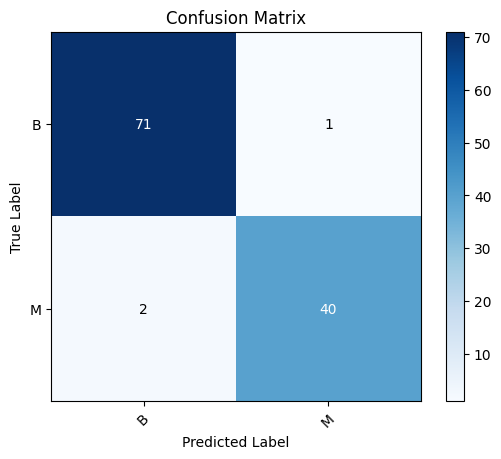

In [22]:
confmat_plot(y_true=y_test, y_pred=y_pred, classes=le.classes_)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall, F1 score, and Matthews correlation coefficient.

    Parameters:
    y_true (array-like): The true labels.
    y_pred (array-like): The predicted labels.

    Returns:
    precision (float): The precision score.
    recall (float): The recall score.
    f1 (float): The F1 score.
    mcc (float): The Matthews correlation coefficient.
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    return precision, recall, f1, mcc

In [25]:
precision, recall, f1, mcc = calculate_metrics(y_true=y_test, y_pred=y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 score: {f1:.3f}')
print(f'Matthews correlation coefficient: {mcc:.3f}')

Precision: 0.976
Recall: 0.952
F1 score: 0.964
Matthews correlation coefficient: 0.943


Use a different metric for grid search CV

In [26]:
# import make_scorer
from sklearn.metrics import make_scorer

c_gamma_range = [0.01, 0.1, 1, 10]

# create param_grid with two settings
# 1. C in c_gamma_range, kernel is linear
# 2. C and gamma in c_gamma_range, kernel is rbf
param_grid = [
    {'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
    {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}
]

# define scorer using f1, positive label is 0
scorer = make_scorer(f1_score, pos_label=0)

# Set up the GridSearchCV
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {gs.best_params_}')
print(f'Best cross-validation score: {gs.best_score_:.3f}')

Best parameters: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best cross-validation score: 0.986


# Imbalanced dataset

In [30]:
# create imbalanced dataset
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [32]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [38]:
from sklearn.utils import resample

# print num of class 1 before resampling
print(f'Number of class 1 samples before resampling: {sum(y_imb == 1)}')

X_upsampled, y_upsampled = resample(X_imb, y_imb, replace=True, n_samples=X_imb.shape[0], random_state=123)

# print num of class 1 after resampling
print(f'Number of class 1 samples after resampling: {X_upsampled.shape[0]}')


Number of class 1 samples before resampling: 40
Number of class 1 samples after resampling: 397
